In [1]:
!pip install python-ternary

In [2]:

import gdown

file_id = "1_IC5uJfMsp1NDuPOapgv4yZl1PtWAbuc"
url = f"https://drive.google.com/uc?id={file_id}"


output = "transformers_with_index.csv"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1_IC5uJfMsp1NDuPOapgv4yZl1PtWAbuc
To: /content/transformers_with_index.csv
100%|██████████| 2.20k/2.20k [00:00<00:00, 5.19MB/s]


'transformers_with_index.csv'

In [3]:
import pandas as pd
import numpy as np

file_path = '/content/transformers_with_index.csv'
data = pd.read_csv(file_path)

np.random.seed(0)
data['Wind'] = 5.03 + np.random.uniform(-1, 1, size=len(data))
data['Rain'] = 836 + np.random.uniform(-100, 100, size=len(data))

data.head()

,name,latitude,longitude,Flood Susceptibility Index,Wind,Rain
0,tran1,45.424363,-75.682130,51,5.127627,758.075028
1,tran2,45.424588,-75.682316,42,5.460379,867.265918
2,tran3,45.424931,-75.682609,47,5.235527,763.636590
3,tran4,45.425487,-75.681855,44,5.119766,775.316472
4,tran5,45.423958,-75.680920,51,4.877310,809.745034


In [4]:
# Normalize columns to be between 0 and 1
columns_to_normalize = ['Flood Susceptibility Index', 'Wind', 'Rain']
data_normalized = data.copy()

for column in columns_to_normalize:
    data_normalized[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())

data_normalized.head()


,name,latitude,longitude,Flood Susceptibility Index,Wind,Rain
0,tran1,45.424363,-75.682130,0.588235,0.546651,0.108717
1,tran2,45.424588,-75.682316,0.411765,0.718246,0.670360
2,tran3,45.424931,-75.682609,0.509804,0.602293,0.137324
3,tran4,45.425487,-75.681855,0.450980,0.542597,0.197401
4,tran5,45.423958,-75.680920,0.588235,0.417566,0.374491


In [5]:
# Save the normalized data to a new CSV file
normalized_file_path = '/content/transformers_data.csv'
data_normalized.to_csv(normalized_file_path, index=False)


In [6]:
import cvxpy as cp
import numpy as np
import pandas as pd

transformer_data_path = '/content/transformers_data.csv'
transformer_data = pd.read_csv(transformer_data_path)

num_scenarios = 61
num_transformers = 6
num_poles = 55

MAX_INTENSITY_LEVEL = 1
# Generate random probabilities matrix with 3 values for flood, wind, and rain features that sum to 1 for each scenario
probabilities = np.random.dirichlet(np.ones(3), num_scenarios)

conditions = transformer_data[['Flood Susceptibility Index', 'Wind', 'Rain']].copy()
conditions.columns = ['flood', 'wind', 'rain']

# Preventive planning costs
cost_upgrade_transformer = 5000
cost_reinforce_pole = 1000

# Decision variables
x_transformers = cp.Variable(num_transformers, boolean=True)  # Upgrade decision for transformers
x_poles = cp.Variable(num_poles, boolean=True)  # Reinforce decision for poles
gamma = cp.Variable(num_scenarios)  # CVaR variables for each scenario
eta = cp.Parameter(nonneg=True)  # Risk threshold (tunable parameter)

# Set a value for eta
eta.value = 50  # Risk tolerance

# Minimize total cost + CVaR penalties
total_upgrade_cost = cost_upgrade_transformer * cp.sum(x_transformers)
total_reinforce_cost = cost_reinforce_pole * cp.sum(x_poles)

# Define risk-aversion parameter
lambda_risk = 0.8  # to control risk aversion level

# Objective function incorporating CVaR
objective = cp.Minimize(
    total_upgrade_cost + total_reinforce_cost +
    (1 - lambda_risk) * cp.sum(cp.multiply(probabilities[:, 0], gamma)) +
    lambda_risk * (eta + cp.sum(gamma))
)

constraints = []

# Constraints based on environmental conditions for each scenario
for i in range(num_scenarios):
    cond = conditions.iloc[i]

    # Preventive actions must ensure resilience based on all environmental condition levels
    min_transformer_upgrades = int(num_transformers * (0.05 + 0.05 * (MAX_INTENSITY_LEVEL - cond['wind']) + 0.05 * (MAX_INTENSITY_LEVEL - cond['flood']) + 0.05 * (MAX_INTENSITY_LEVEL - cond['rain'])))
    min_pole_reinforcements = int(num_poles * (0.1 + 0.05 * (MAX_INTENSITY_LEVEL - cond['flood']) + 0.05 * (MAX_INTENSITY_LEVEL - cond['rain']) + 0.05 * (MAX_INTENSITY_LEVEL - cond['wind'])))

    constraints.append(cp.sum(x_transformers) >= min_transformer_upgrades)
    constraints.append(cp.sum(x_poles) >= min_pole_reinforcements)

    # CVaR constraints: gamma[s] >= scenario cost - eta
    scenario_cost = (cost_upgrade_transformer * min_transformer_upgrades +
                     cost_reinforce_pole * min_pole_reinforcements)
    constraints.append(gamma[i] >= scenario_cost - eta)
    constraints.append(gamma[i] >= 0)

# Solve the optimization problem
problem = cp.Problem(objective, constraints)
result = problem.solve()

# Results
print("Optimal Preventive Planning Cost: $", result)
print("Transformers to Upgrade:", sum(x_transformers.value))
print("Poles to Reinforce:", sum(x_poles.value))
print("CVaR values per scenario:", gamma.value)


Optimal Preventive Planning Cost: $ 502783.79977197456
Transformers to Upgrade: 1.0
Poles to Reinforce: 12.0
CVaR values per scenario: [ 9950.  7950.  9950.  9950.  8950.  6950. 10950.  7950.  8950.  7950.
  8950.  7950.  8950.  6950. 10950. 10950. 16950.  8950.  7950.  7950.
  6950.  8950.  8950.  7950. 10950.  8950. 10950.  6950.  7950.  9950.
  9950.  8950.  8950.  9950. 10950.  8950.  9950.  7950.  8950.  7950.
  9950.  6950.  5950.  9950.  6950.  7950.  9950. 10950.  7950.  9950.
  7950.  8950.  6950.  9950. 16950.  8950.  8950.  8950.  7950.  8950.
  8950.]


In [7]:

cvar_df = pd.DataFrame(gamma.value, columns=['CVaR'])

transformer_data = transformer_data.reset_index(drop=True)

final_data = pd.concat([transformer_data, cvar_df], axis=1)

final_data.to_csv('final.csv', index=False)

In [8]:
final_data['CVaR_normalized'] = (final_data['CVaR'] - final_data['CVaR'].min()) / (final_data['CVaR'].max() - final_data['CVaR'].min())

final_data.to_csv('final.csv', index=False)

In [9]:
import pandas as pd

final_data = pd.read_csv('final.csv')

min_cvar_scenario = final_data['CVaR'].idxmin()
max_cvar_scenario = final_data['CVaR'].idxmax()

# Get the corresponding CVaR values
min_cvar_value = final_data['CVaR'].iloc[min_cvar_scenario]
max_cvar_value = final_data['CVaR'].iloc[max_cvar_scenario]

print(f"Scenario with minimum CVaR: {min_cvar_scenario + 1}, CVaR value: {min_cvar_value}")
print(f"Scenario with maximum CVaR: {max_cvar_scenario + 1}, CVaR value: {max_cvar_value}")

Scenario with minimum CVaR: 43, CVaR value: 5950.0
Scenario with maximum CVaR: 17, CVaR value: 16950.0


In [10]:
# importing font
file_id = "1mliEg2ZcWfTRD-1LdzVy7_r3Ep66Lpet"
url = f"https://drive.google.com/uc?id={file_id}"


output = "Times New Roman.ttf"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1mliEg2ZcWfTRD-1LdzVy7_r3Ep66Lpet
To: /content/Times New Roman.ttf
100%|██████████| 834k/834k [00:00<00:00, 27.7MB/s]


'Times New Roman.ttf'

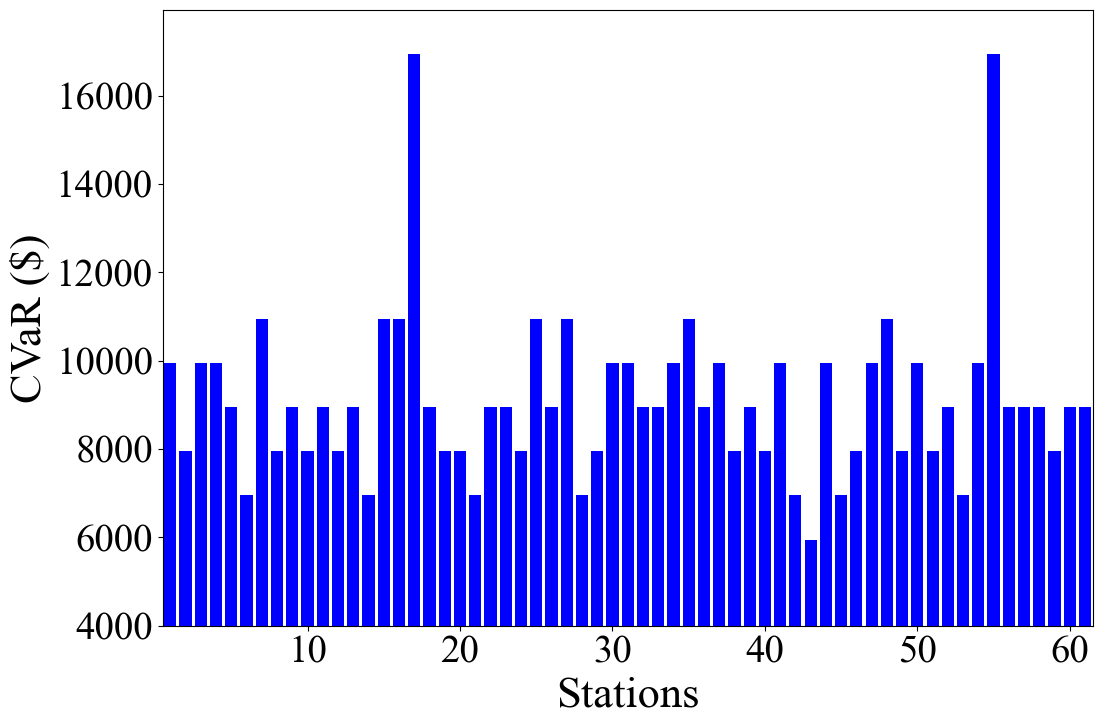

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties, fontManager

# Define the font path and register it with matplotlib
font_path = "/content/Times New Roman.ttf"
font_prop = FontProperties(fname=font_path)
fontManager.addfont(font_path)
plt.rcParams['font.family'] = font_prop.get_name()  # Use the registered font globally

# Assuming cvar_values is defined with actual data
cvar_values = gamma.value  # Make sure this variable contains your data
Stations = np.arange(1, len(cvar_values) + 1)

plt.figure(figsize=(12, 8))

plt.bar(Stations, cvar_values, color='b')
plt.xlabel('Stations', fontsize=32)
plt.ylabel('CVaR ($)', fontsize=32)
# plt.title('CVaR vs. Scenarios', fontsize=16)

# Set font sizes for tick labels
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

# Set y-axis limits to start from 4000
plt.ylim(4000, max(cvar_values) + 1000)

# Adjust x-axis limits to remove extra space before the first and after the last bar
plt.xlim(Stations[0] - 0.5, Stations[-1] + 0.5)

# Uncomment to add gridlines only for the y-axis
# plt.grid(axis='y')

# Save the figure with tight bounding box to avoid cropping
plt.savefig("cvar_scenarios.pdf", format="pdf", bbox_inches="tight")

plt.show()
plt.close()


In [12]:
import cvxpy as cp
import numpy as np
import pandas as pd

# Define file path for transformer data
transformer_data_path = '/content/transformers_data.csv'
transformer_data = pd.read_csv(transformer_data_path)

# Define constants
num_scenarios = 61
num_transformers = 6
num_poles = 55

MAX_INTENSITY_LEVEL = 1
# Preventive planning costs
cost_upgrade_transformer = 5000
cost_reinforce_pole = 1000

# Risk-aversion parameter and eta
lambda_risk = 0.8
eta_value = 50

# To store gamma values across runs
all_gamma_values = []

# Run the optimization problem 50 times
for run in range(50):
    # Set a unique seed for each run
    np.random.seed(run)

    # Generate random probabilities matrix for each scenario
    probabilities = np.random.dirichlet(np.ones(3), num_scenarios)

    # Decision variables
    x_transformers = cp.Variable(num_transformers, boolean=True)
    x_poles = cp.Variable(num_poles, boolean=True)
    gamma = cp.Variable(num_scenarios)
    eta = cp.Parameter(nonneg=True)
    eta.value = eta_value

    total_upgrade_cost = cost_upgrade_transformer * cp.sum(x_transformers)
    total_reinforce_cost = cost_reinforce_pole * cp.sum(x_poles)

    objective = cp.Minimize(
        total_upgrade_cost + total_reinforce_cost +
        (1 - lambda_risk) * cp.sum(cp.multiply(probabilities[:, 0], gamma)) +
        lambda_risk * (eta + cp.sum(gamma))
    )

    constraints = []
    conditions = transformer_data[['Flood Susceptibility Index', 'Wind', 'Rain']].copy()
    conditions.columns = ['flood', 'wind', 'rain']

    for i in range(num_scenarios):
        cond = conditions.iloc[i]
        min_transformer_upgrades = int(num_transformers * (0.05 + 0.05 * (MAX_INTENSITY_LEVEL - cond['wind']) + 0.05 * (MAX_INTENSITY_LEVEL - cond['flood']) + 0.05 * (MAX_INTENSITY_LEVEL - cond['rain'])))
        min_pole_reinforcements = int(num_poles * (0.1 + 0.05 * (MAX_INTENSITY_LEVEL - cond['flood']) + 0.05 * (MAX_INTENSITY_LEVEL - cond['rain']) + 0.05 * (MAX_INTENSITY_LEVEL - cond['wind'])))

        constraints.append(cp.sum(x_transformers) >= min_transformer_upgrades)
        constraints.append(cp.sum(x_poles) >= min_pole_reinforcements)

        scenario_cost = (cost_upgrade_transformer * min_transformer_upgrades +
                         cost_reinforce_pole * min_pole_reinforcements)
        constraints.append(gamma[i] >= scenario_cost - eta)
        constraints.append(gamma[i] >= 0)

    problem = cp.Problem(objective, constraints)
    problem.solve()

    gamma_values_run = gamma.value
    all_gamma_values.append(gamma_values_run)

gamma_df = pd.DataFrame(all_gamma_values)
gamma_avg = gamma_df.mean()

gamma_avg.to_csv('average_gamma_values.csv', index_label='Scenario', header=['Average Gamma'])

print("Average gamma values over 50 runs have been saved to 'average_gamma_values.csv'")


Average gamma values over 50 runs have been saved to 'average_gamma_values.csv'


In [13]:
import pandas as pd

gamma_df = pd.read_csv('average_gamma_values.csv')

average_gamma = gamma_df['Average Gamma'].mean()
min_gamma = gamma_df['Average Gamma'].min()
max_gamma = gamma_df['Average Gamma'].max()

min_index = gamma_df['Average Gamma'].idxmin()
max_index = gamma_df['Average Gamma'].idxmax()

print("Summary of Average Gamma Values:")
print(f"Overall Average Gamma: {average_gamma}")
print(f"Minimum Gamma: {min_gamma} (at index {min_index})")
print(f"Maximum Gamma: {max_gamma} (at index {max_index})")


Summary of Average Gamma Values:
Overall Average Gamma: 9130.327868852459
Minimum Gamma: 5950.0 (at index 42)
Maximum Gamma: 16950.0 (at index 16)
